## Training a probabilsitic autoencoder to classify FeLoBAL

In [1]:
# import this package 
from pytorch_pae import AE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.table import Table
from scipy import stats
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from astropy.io import fits
# from specbox import SpecSDSS
import multiprocessing

In [3]:
# import pytorch
import torch

print(torch.__version__)

1.13.1


In [4]:
from torchinfo import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from scipy import stats
from scipy.signal import savgol_filter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from glob import glob
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Step 1: Choose your parameters

In [7]:
## data parameters
dataset       = 'FelobalSimple'
loc           = './Datasets'

# number of layers in networks
n_layers     = 8

### convolutional net specific parameters ###

### Convolutions
# number of channels in each layer for convolutional neural net
# out_channels = [16,16,16]
out_channels = [3,3,3,3,1,1,1,1]
# kernel sizes in each layer for conv net
kernel_sizes = [3,3,3,3,3,3,3,3]
# padding values in each conv layer
paddings     = [1,1,1,1,1,1,1,1] #TODO: add suport for 'VALID' and 'SAME'
# stride values in each conv layer
strides      = [1,1,1,1,1,1,1,1]

### Pooling
# scaling factor in max pooling layer 
scale_facs   = [1,1,1,1,1,1,1,1] 

### Normalization
# whether t0 apply a layer normalization after conv layer
layer_norm   = [True,True,True,True,True,True,True,True,True]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False
#############################################


### fully connected net specific parameters ###

# output size of each fully connected layer
# out_sizes    = [256,128,128]
# whether to add a bias in each layer or not
bias         = [True, True, True, True, True, True, True, True, True]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.4,0.4,0.4,0.5,0.5,0.7,0.7,0.8]

# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = True
# activation function after each layer

activations  = ['ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU']

# ##############################################


########### general parameters ###########
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 64
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 3522

# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'conv'
decoder_type = 'conv'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = True
########################################


########## Training parameters #########
nepochs         = 200
batchsize       = 64
batchsize_valid = 128
initial_lr      = 1e-2

optimizer        = 'Adam'
# choose one of pytorch's or define your own
criterion1       = 'MSELoss'
criterion2       = 'MSELoss'
# when to switch from criterion1 to criterion2
ann_epoch        = 500

# choose one of pytorch's or define your own
scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}

##### Just for contrastive learning --> ignore
contrastive      = False
tau              = 0.05
hidden_dim       = 2
########################################

In [8]:
general_params      = {'input_c': input_c, 
                       'input_dim': input_dim, 
                       'latent_dim': latent_dim, 
                       'encoder_type': encoder_type, 
                       'decoder_type': decoder_type,
                       'contrastive':contrastive, 
                       'dim': dim, 
                       'hidden_dim':hidden_dim}
conv_network_params = {'n_layers': n_layers, 
                       'out_channels': out_channels, 
                       'kernel_sizes': kernel_sizes, 
                       'scale_facs': scale_facs, 
                       'paddings': paddings,
                       'strides': strides,
                       'activations': activations, 
                       'spec_norm': spec_norm, 
                       'layer_norm': layer_norm,
                       'affine': affine,
                       'final_sigmoid': final_sigmoid, 
                       'bias':bias}
# fc_network_params   = {'n_layers': n_layers, 
#                        'out_sizes': out_sizes,
#                        'activations': activations, 
#                        'spec_norm': spec_norm, 
#                        'dropout_rate':dropout_rate, 
#                        'layer_norm': layer_norm, 
#                        'affine': affine, 
#                        'final_sigmoid': final_sigmoid, 
#                        'bias':bias}

training_params     = {'batchsize': batchsize, 
                       'initial_lr': initial_lr, 
                       'optimizer': optimizer, 
                       'criterion1': criterion1, 
                       'criterion2': criterion2, 
                       'scheduler': scheduler, 
                       'scheduler_params':scheduler_params, 
                       'batchsize_valid': batchsize_valid, 
                       'ann_epoch':ann_epoch}
data_params         = {'dataset':dataset, 'loc': loc}

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float)

## Step 2: Set up and train the autoencoder

In [10]:
AE1 = AE.Autoencoder(params=general_params,
                     dparams=data_params,
                     nparams_enc=conv_network_params, 
                     nparams_dec=conv_network_params, 
                     tparams=training_params, 
                     device=device, 
                     transforms=None)

In [11]:
# summary?

In [12]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

In [13]:
summary(AE1, (input_c, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 1, 3522]              --
├─ConvEncoder: 1-1                       [1, 64]                   --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Conv1d: 3-1                  [3, 3522]                 12
│    │    └─LayerNorm: 3-2               [3, 3522]                 --
│    │    └─ReLU: 3-3                    [3, 3522]                 --
│    │    └─AdaptiveMaxPool1d: 3-4       [3, 3522]                 --
│    │    └─Conv1d: 3-5                  [3, 3522]                 30
│    │    └─LayerNorm: 3-6               [3, 3522]                 --
│    │    └─ReLU: 3-7                    [3, 3522]                 --
│    │    └─AdaptiveMaxPool1d: 3-8       [3, 3522]                 --
│    │    └─Conv1d: 3-9                  [3, 3522]                 30
│    │    └─LayerNorm: 3-10              [3, 3522]                 --
│    │    └─ReL

In [14]:
AE1.train_loader.dataset.__getitem__([0])['features'].shape

torch.Size([1, 3522])

In [15]:
train_loss, valid_loss = AE1.train_autoencoder(nepochs)

epoch: 1, training loss: 9.9182e-01, validation loss: 9.5281e-01, learning rate: 1.0000e-02
epoch: 2, training loss: 9.3631e-01, validation loss: 9.1583e-01, learning rate: 9.8000e-03
epoch: 3, training loss: 9.1389e-01, validation loss: 8.9968e-01, learning rate: 9.6040e-03
epoch: 4, training loss: 8.9074e-01, validation loss: 8.7578e-01, learning rate: 9.4119e-03
epoch: 5, training loss: 8.7265e-01, validation loss: 8.7154e-01, learning rate: 9.2237e-03
epoch: 6, training loss: 8.5507e-01, validation loss: 8.5045e-01, learning rate: 9.0392e-03
epoch: 7, training loss: 8.3868e-01, validation loss: 8.3239e-01, learning rate: 8.8584e-03
epoch: 8, training loss: 8.1807e-01, validation loss: 8.1223e-01, learning rate: 8.6813e-03
epoch: 9, training loss: 8.0321e-01, validation loss: 7.8294e-01, learning rate: 8.5076e-03
saved model to "./AE.ckpt"
epoch: 10, training loss: 7.8208e-01, validation loss: 7.6808e-01, learning rate: 8.3375e-03
epoch: 11, training loss: 7.7240e-01, validation los

In [16]:
AE1.load_model('.')

True

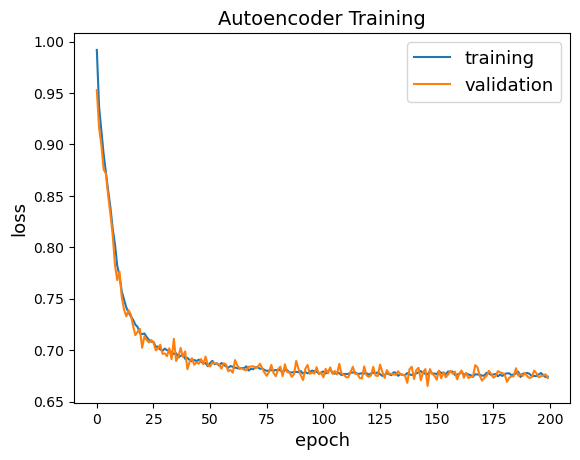

In [17]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Data reconstructions

In [18]:
from pytorch_pae.data_loader import *

In [19]:
data_params['dataset']

'FelobalSimple'

In [20]:
train_loader, valid_loader, test_loader= get_data(data_params['dataset'],data_params['loc'],16, 16, transforms=None)

data = next(iter(train_loader))
data = data['features']
data = data.view(-1, 1, data.shape[1])

recon = AE1.forward(data.to(device))

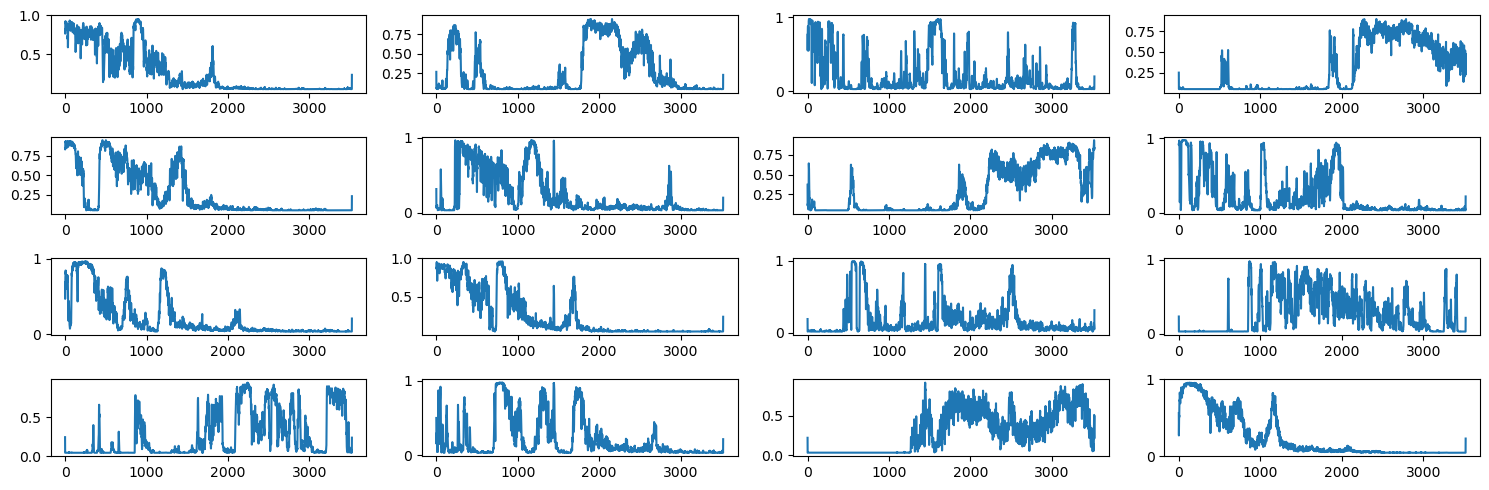

In [21]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(recon[ii].cpu().detach().numpy()))
plt.tight_layout()
plt.show()

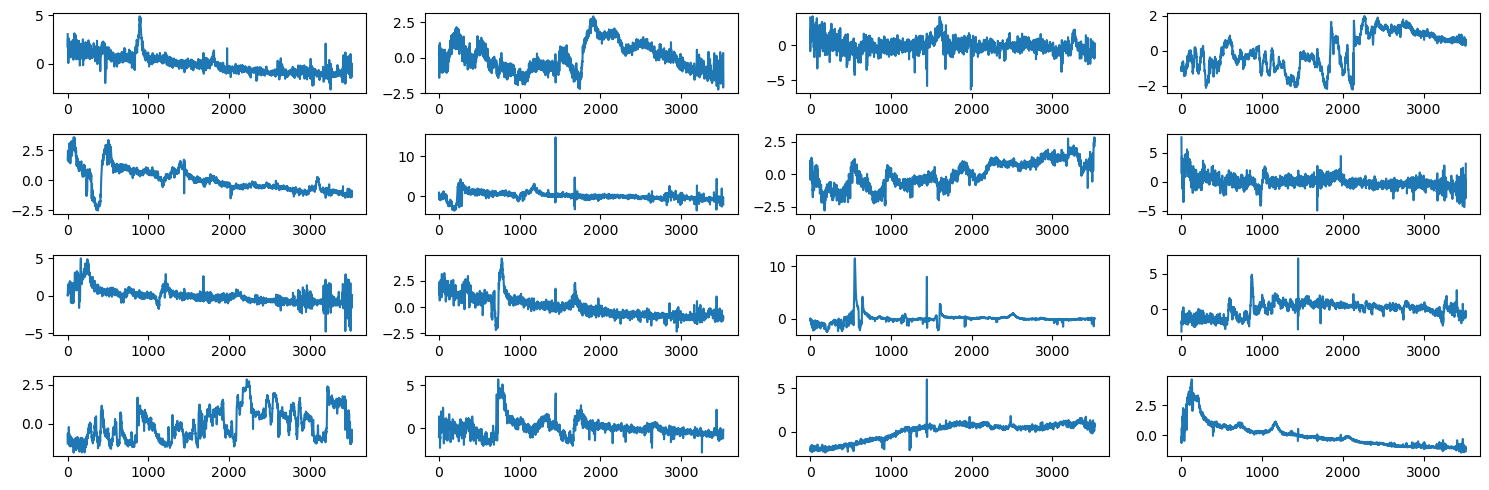

In [22]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data[ii].cpu().detach().numpy()))
plt.tight_layout()
plt.show()

In [23]:
from pathlib import Path
Path('Models/Tutorials').mkdir(exist_ok=True, parents=True)

In [24]:
torch.save(AE1, os.path.join('./Models/Tutorials', 'AE'))

## Step 3: Train the density estimator on the encoded data

In [25]:
# import density estimation module
from sinf import GIS

In [26]:
# load auutoencoder
AE1 = torch.load(os.path.join('./Models/Tutorials', 'AE'))

In [27]:
from pytorch_pae.data_loader import *

In [28]:
# encode data

train_loader, valid_loader, test_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1, transforms=None)

data = next(iter(train_loader))
data = data['features']
data = data.view(-1, 1, data.shape[1])
data = data.to(device)

valid_data = next(iter(valid_loader))
valid_data = valid_data['features']
valid_data = valid_data.view(-1, 1, valid_data.shape[1])
valid_data     = valid_data.to(device)

with torch.no_grad():
    encoded_train = AE1.encoder.forward(data)
    encoded_valid = AE1.encoder.forward(valid_data)

In [29]:
encoded_train.shape

torch.Size([838, 64])

In [30]:
encoded_valid.shape

torch.Size([838, 64])

In [31]:
encoded_train.device

device(type='cuda', index=0)

In [32]:
# train density estimator (set verbose=True to see training progress)
gis = GIS.GIS(data_train=encoded_train, 
              data_validate=encoded_valid,
              iteration=200,
              verbose=False, 
              nocuda=False)

/gpfs/share/home/2106395012/tools/SINF/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  Q, R = torch.qr(ATi)


In [33]:
torch.save(gis, os.path.join('./Models/Tutorials', 'GIS'))

## Density Estimation and Outlier Detection

In [34]:
logps       = gis.evaluate_density(encoded_train)
logps_valid = gis.evaluate_density(encoded_valid)

In [35]:
logps       = logps.cpu().detach().numpy()
logps_valid = logps_valid.cpu().detach().numpy()

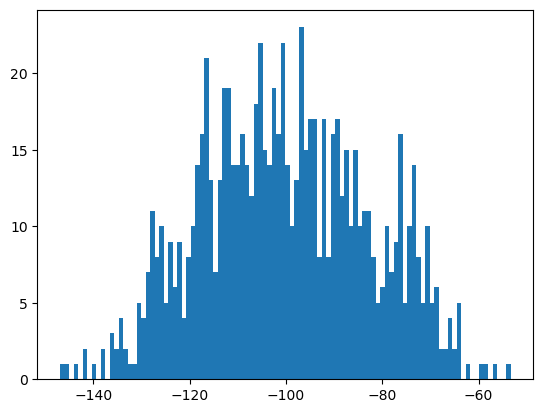

In [36]:
_       = plt.hist(logps,bins=100)

In [37]:
ranking = np.argsort(logps)

### Digits with lowest probability

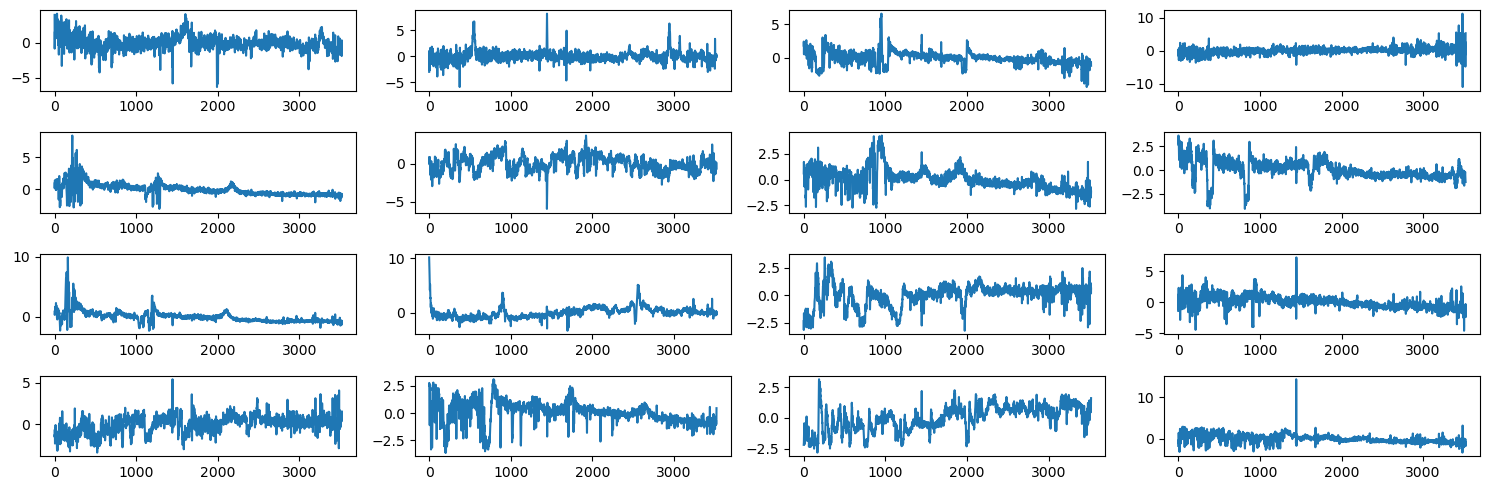

In [38]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data[ranking[ii]].cpu().detach().numpy()))
plt.tight_layout()
plt.show()

In [39]:
np.squeeze(data[ranking[ii]].cpu().detach().numpy())

array([-1.667022  , -0.31408605, -1.0503658 , ..., -1.1859335 ,
       -1.7278997 , -0.8728662 ], dtype=float32)

## Data Generation

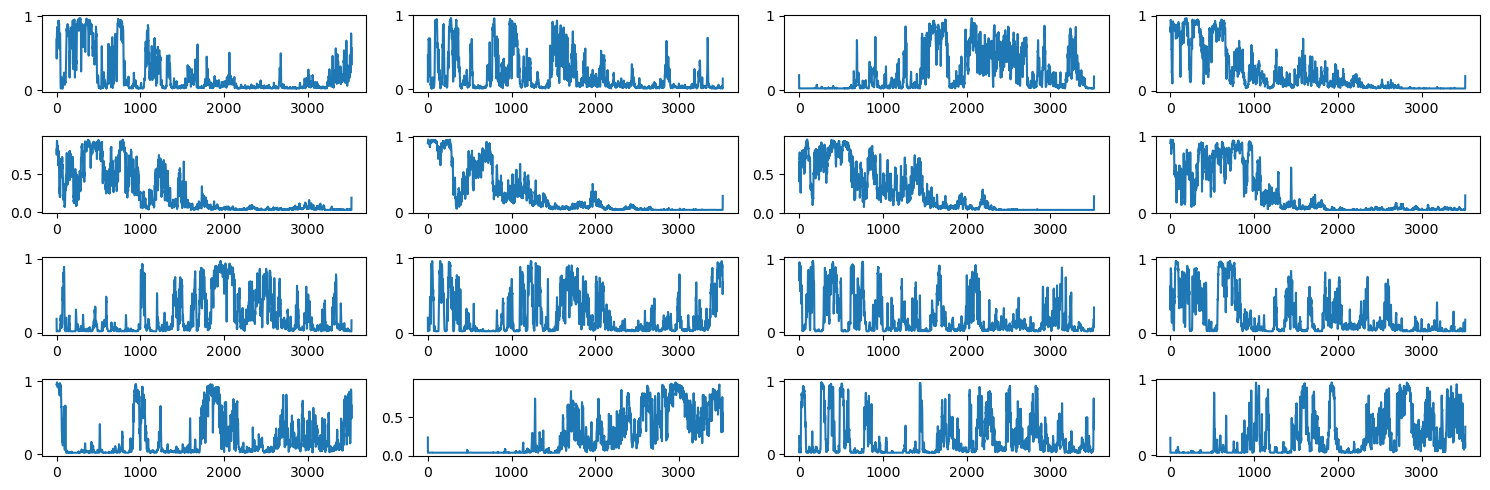

In [40]:
samples, _ = gis.sample(16)
with torch.no_grad():
    decoded_samples = AE1.decoder.forward(samples)

fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(decoded_samples[ii].cpu().detach().numpy()))
plt.tight_layout()
plt.show()
